<p style='color:#5A20CB'>Deep learning systems are often trained on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other deep learning libraries, but Tensorflow makes it easy thanks to the Data API: You just create a dataset object, and tell it where to get the data and how to transform it. Tensorflow takes care of all the implementation details, such as multithreading, queuing, batching, and prefetching. Moreover, the Data API works seemlessly with tf.keras.</p>

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">The Data API</h2>

 <p style='color:#5A20CB'>The whole Data API revolves around the concept of a dataset: this represents a sequence of data items. Usually you will use datasets that gradually read data from disk, but for simplicity let's create a dataset entirely in RAM using <strong>tf.data.Dataset.from_tensor_slices()</strong>:</p>

In [27]:
import tensorflow as tf

In [28]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

 <p style='color:#5A20CB'>The <strong>from_tensor_slices()</strong> function takes a tensor and creates a <strong>tf.data.Dataset</strong> whose elements are all the slices of X <u>(along the first dimension)</u>, so this dataset contains 10 items: tensors 0,1,2,3,...,9. In this case, we would have obtained the same dataset if we had used <strong>tf.data.Dataset.range(10)</strong>. You can simply iterate over a dataset's items like this:</p>

In [29]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Chaining Transformations</h2>

<p style='color:#5A20CB'>Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset, so you can chain transformations like this:</p>

In [30]:
dataset = dataset.repeat(4).batch(6)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([6 7 8 9 0 1], shape=(6,), dtype=int32)
tf.Tensor([2 3 4 5 6 7], shape=(6,), dtype=int32)
tf.Tensor([8 9 0 1 2 3], shape=(6,), dtype=int32)
tf.Tensor([4 5 6 7 8 9], shape=(6,), dtype=int32)
tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([6 7 8 9], shape=(4,), dtype=int32)


<p style='color:#5A20CB'><strong>batch()</strong> method will group the items of the previous dataset in batches. You can even call it with <strong>drop_remainder=True</strong> if you want it to drop this final batch so that all batches have the exact same size.</p>

<p style='color:#5A20CB'>Teh dataset methods do not modify datasets, they create new ones, so make sure to keep a reference to these new datasets or else nothing will happen.</p>

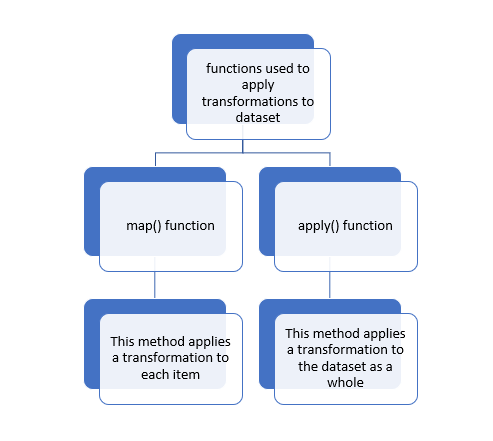

In [31]:
dataset = dataset.map(lambda x: x*2)

<p style='color:#5A20CB'>This function is the one you will call to apply any preprocessing you want to your data. Sometimes this will include computations that can be quite intensive, such as reshaping or rotating an image, so you will usually want to spawn multiple threads to speed things up: it's as simple as setting the <strong>num_parallel_calls</strong> argument. Note that the function you pass to the map() must be convertible to the TF Function.</p>

In [32]:
dataset = dataset.apply(tf.data.experimental.unbatch())

<p style='color:#5A20CB'>It is also possible to simply filter the dataset using the <strong>filter()</strong> method.</p>

In [33]:
dataset = dataset.filter(lambda x: x<10)

<p style='color:#5A20CB'>We can also take a look at few items from a dataset using <strong>take()</strong> method.</p>

In [34]:
for item in dataset.take(2):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Shuffling the data</h2>

<p style='color:#5A20CB'>Gradient descent works best when the instances in the training set are independent and identiacally distributed. A simple way to ensure this is to shuffle the instances, using the <strong>shuffle()</strong> method.</p>

<p style='color:#5A20CB'>A buffer is like a cache, that is a data area of computer memory (RAM) reserved for temporary storage.</p>

<p style='color:#5A20CB'>Gradient descent works best when the instances in the training set are independent and identiacally distributed. A simple way to ensure this is to shuffle the instances, using the <strong>shuffle()</strong> method.</p>

<p style='color:#5A20CB'>The <strong>shuffle()</strong> method will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point it continues to pull out items randomly from the buffer until it is empty. You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective. You can provide a random seed if you want the same random order every time you run your program.</p>

In [35]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=23).batch(7)
for item in dataset:
    print(item)

tf.Tensor([2 5 4 6 1 0 0], shape=(7,), dtype=int64)
tf.Tensor([1 3 9 4 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([8 7 0 7 2 6 3], shape=(7,), dtype=int64)
tf.Tensor([1 6 4 8 9 5 9], shape=(7,), dtype=int64)
tf.Tensor([7 8], shape=(2,), dtype=int64)


<p style='color:#5A20CB'>For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset. One solution is to shuffle the source data itself. This will definitely improve shuffling a lot! Even if  the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data's order).</p>

<p style='color:#5A20CB'>To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training. However, instances located in the same file will still end up close to each other. To avoid this you can pick mulitple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using <strong>shuffle()</strong> method.</p>

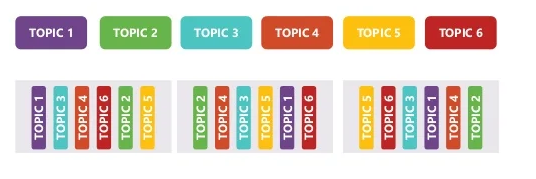

In [36]:
## here let's use the iris flower dataset for demo. The data is split into two csv files

train_file_path = './Data/Train/Train*.csv'

filepath_dataset = tf.data.Dataset.list_files(train_file_path, seed=32)

In [37]:
filepath_dataset

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

<p style='color:#5A20CB'>By default, the <strong>list_files()</strong> function returns a dataset that shuffles the file paths. In general this is a good thing, but you can set <strong>shuffle=False</strong> if you do not want that for some reason.</p>

<p style='color:#5A20CB'>Next, you can call the <strong>interleave()</strong> method to read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the <strong>skip()</strong> method.</p>

In [38]:
n_readers = 2
dataset = filepath_dataset.interleave(
            lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
            cycle_length=n_readers)

In [39]:
dataset

<InterleaveDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

<p style='color:#5A20CB'>The <strong>interleave</strong> method will create a dataset that will pull two file paths from the filepath_dataset, and for each one it will call the function you gave it (a lambda one in this case) to create a new dataset.</p>
<p style='color:#5A20CB'>For interleaving to work best, it is preferable to have files of identical length; otherwise the ends of the longest files will not be interleaved.</p>
<p style='color:#5A20CB'>By default, <strong>interleave()</strong> does not use parallelism; it just reads one line at a time from each file, sequentially. If you want it to actually read files in parallel, you can set the <strong>num_parallel_calls</strong> argument to the number of threads that you want (note that the <strong>map()</strong> method also has this argument).</p>

In [40]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'80,5.7,2.6,3.5,1,Iris-versicolor', shape=(), dtype=string)
tf.Tensor(b'1,5.1,3.5,1.4,0.2,Iris-setosa', shape=(), dtype=string)
tf.Tensor(b'81,5.5,2.4,3.8,1.1,Iris-versicolor', shape=(), dtype=string)
tf.Tensor(b'2,4.9,3,1.4,0.2,Iris-setosa', shape=(), dtype=string)
tf.Tensor(b'82,5.5,2.4,3.7,1,Iris-versicolor', shape=(), dtype=string)


<p style='color:#5A20CB'>Note the output of the above line of code. These are just byte strings; we need to parse them.</p>

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Preprocessing the data</h2>

In [41]:
## Let's implement a small function that will perform preprocessing on the dataset

def preprocess(line):
    defaults = [0.] * 5 + [tf.constant([], dtype=tf.string)]
    fields = tf.io.decode_csv(line, record_defaults=defaults)
    x = tf.stack(fields[1:-1])
    y = tf.stack(fields[-1:])
    return x,y

<p style='color:#5A20CB'>Let's walk through the above code.</p>
<p style='color:#5A20CB'>The preprocess function takes one CSV line and starts by parsing it. For this it uses <strong>tf.io.decode_csv</strong> function, which takes two arguments: the first is the line to parse, and the second is an array containing the default value for each column in CSV file. This array tells Tensorflow not only the default values for each column, but also the number of columns and their types. In this example, we tell it that all feature columns are floats and that missing values should default to 0, but we provide an empty array of type tf.string as the default value for hte last column (the target): the array tells Tensorflow that this column contains floats, but that there is no default value, so it will raise an exception if it encounters a missing value.</p>
<p style='color:#5A20CB'>The <strong>decode_csv()</strong> function returns a list of scalar tensors (one per column), but we need to return 1D tensor arrays. So we call <strong>tf.stack()</strong> on all tensors except for the last one (the target): this will stack these tensors into a 1D array. We then do the same for the target value (this makes it a 1D tensor array with a single value, rather thans a scalar tensor</p>

In [42]:
## let's test this
preprocess(b'80,5.7,2.6,3.5,1,Iris-versicolor')

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.7, 2.6, 3.5, 1. ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Iris-versicolor'], dtype=object)>)

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Putting everything together</h2>

In [43]:
def csv_reader_dataset(filepaths, repeat=1, n_reader=2, n_read_threads=None, shuffle_buffer_size=20,
                       n_parse_threads=5,batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads
    )
    dataset = dataset.map(preprocess, num_parallet_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return dataset.batch(batch_size).prefetch(1)

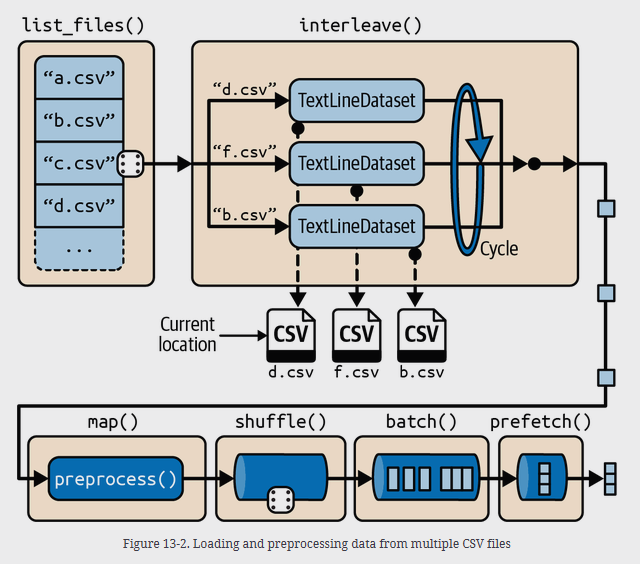

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Prefetching</h2>

<p style='color:#5A20CB'>By calling <strong>prefetch(1)</strong> at the end, we are creating a dataset that will do its best to always be one batch ahead. In other words, while our training algorighm is working on one batch, the dataset will already be working in parallel on gettting the next batch ready (e.g., reading the data from disk and preprocessing it). If we also ensure that loading and preprocessing are multithreaded (by setting num_parallel_calls when calling <strong>interleave()</strong> and <strong>map()</strong>, we can exploit mulitple cores on the CPU and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU), and training will run much faster.</p>

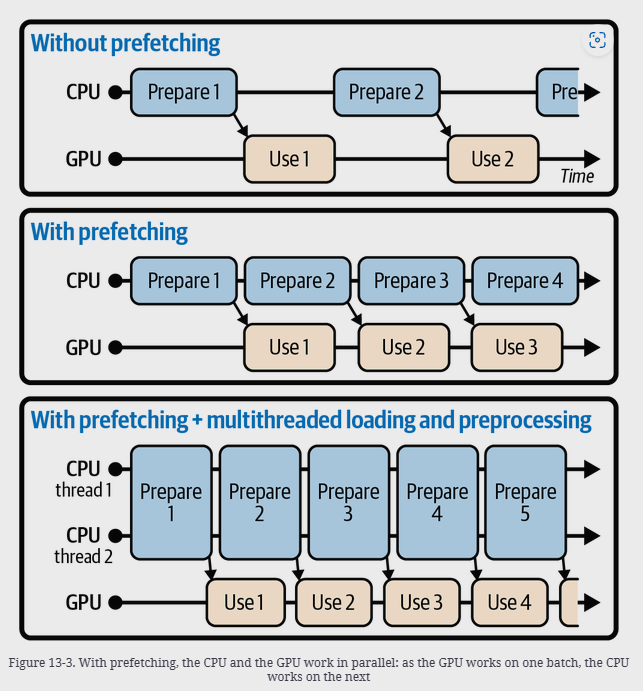

<p style='color:#5A20CB'><u>If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset's <strong>cache()</strong> method to cache its content in RAM. You should generally do this after loading and preprocessing the data, but before shuffling, repeating, batching and prefetching. This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will be shuffled differently at each epoch, and the next batch will still be prepared in advance.<u.></p>

In [44]:
def csv_reader_dataset(filepaths, repeat=1, n_reader=2, n_read_threads=None, shuffle_buffer_size=20,
                       n_parse_threads=5,batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads
    )
    dataset = dataset.map(preprocess, num_parallet_calls=n_read_threads)
    dataset = dataset.cache()
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return dataset.batch(batch_size).prefetch(1)

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Using the Dataset with tf.keras</h2>

<pre>
train_set = csv_reader_dataset(train_filepaths)
validation_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

model = keras.models.Sequential([...])
model.compile([...])
model.fit(train_set, epochs=10, validation_data=valid_set)

model.evaluate(test_set)
new_set = test_set.take(3).map(lambda X,y: X)
model.predict(new_set)
</pre>

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">The TFRecord Format</h2>

<p style='color:#5A20CB'>The TFRecord format is Tensorflow's preferred format for storing large amount of data and reading it efficiently. It is very simple binary format that just contains a sequence of binary records of varying sizes (each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data). You can easily create a TFRecord file using the <strong>tf.io.TFRecordWriter</strong> class</p>

In [45]:
with tf.io.TFRecordWriter('./Data/my_data.tfrecord') as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

<p style='color:#5A20CB'>You can use a <strong>tf.data.TFRecordDataset</strong> to read one or more TFRecord files.</p>

In [46]:
filepaths = ['./Data/my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


<p style='color:#5A20CB'>By default, a <strong>TFRecordDataset</strong> will read files one by one, but you can make it read mulitple files in parallel and interleave their records by setting <strong>num_parallet_reads</strong>. Alternatively, you could obtain the same result by using list_files() and interleave() as we did earlier to read multiple CSV files.</p>

<h2 style="border:1px solid white;background-color:#66AD47;text-align:center;padding:10px;border-radius:5px">Compressed TFRecord Files</h2>

<p style='color:#5A20CB'>It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection. You can create a compressed TFRecord file by setting the options argument.</p>

In [47]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('./Data/my_compressed_file.tfrecord', options) as f:
    f.write(b"This is a data entry one.")
    f.write(b"This is a data entry two.")

In [48]:
dataset = tf.data.TFRecordDataset('./Data/my_compressed_file.tfrecord', compression_type='GZIP')
for item in dataset:
    print(item)

tf.Tensor(b'This is a data entry one.', shape=(), dtype=string)
tf.Tensor(b'This is a data entry two.', shape=(), dtype=string)
